In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import colorcet as cc

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [3]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [4]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [5]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

# Summer > 70

In [13]:
ice_ds_201809 = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201809.nc")

In [8]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBinsOver70 = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMaskOver70 = community.hexMask(myBinsOver70, -180, 180, 60, 90)
myMaskOver70.growToLevel(4)
myBinsOver70.calculate_voronoi(myMaskOver70, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBinsOver70.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBinsOver70.oceanMask = pickle.load(pickFile)

In [9]:
myBinsOver70.oceanMask = np.logical_and(myBinsOver70.oceanMask, myBinsOver70.lats[myBinsOver70.mask[3]] > 70)
transMaskOver70 = myBinsOver70.lats[myBinsOver70.mask[3]][myBins.oceanMask] > 70

In [13]:
transMaskOver70

array([ True, False, False, ...,  True,  True,  True])

In [14]:
pset_201809 = xr.open_dataset(psetdir + "pset_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24.nc")

In [11]:
inDomain = pset_201809.lat[:,0]>70

In [26]:
outBounder = np.nonzero(pset_201809.lat[inDomain,:] <70)
n = pset_201809.lat[inDomain,:].shape[0]

In [28]:
terminalIndex = np.ones(n)*90

In [46]:
saved = set()
for i in range(outBounder.shape[1]):
    currPart = int(outBounder[0,i].values)
    if currPart not in saved:
        saved.update([currPart])
        terminalIndex[currPart] = int(outBounder[1, i])

In [155]:
lonlatInit = np.dstack((pset_201809.lon[inDomain, 0], pset_201809.lat[inDomain, 0]))

In [90]:
lonFinal = pset_201809.lon[inDomain, :].data[np.arange(n), terminalIndex.astype('int')]

In [95]:
latFinal = pset_201809.lat[inDomain, :].data[np.arange(n), terminalIndex.astype('int')]

In [156]:
lonlatFinal = np.dstack((lonFinal, latFinal))

In [157]:
transMat_20180301_over70 = community.transMat.from_lonlat(lonlatInit, 
                                                       lonlatFinal, 
                                                       countBins = myBinsOver70, 
                                                       mask = myBinsOver70.oceanMask)
transMat_20180301_over70.save_counter(matdir + f"masked_counter_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel")
transMat_20180301_over70.save_network(netdir + f"masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel.net")

 Determining particle bins. 100%

In [17]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7.npz")
transMat_20180301_over70 = community.transMat.from_counter_npz(matdir + f"masked_counter_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel.npz")

What percentage of entries of the transition matrix with particles terminated below 70N is equal to the original transition matrix?

In [27]:
np.sum(np.sum(transMat_20180301.data[transMaskOver70, :][:, transMaskOver70] == transMat_20180301_over70.data, axis=0) == np.ones(4344)*4344)/4344

0.666206261510129

(<Figure size 432x288 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fe3918266a0>)

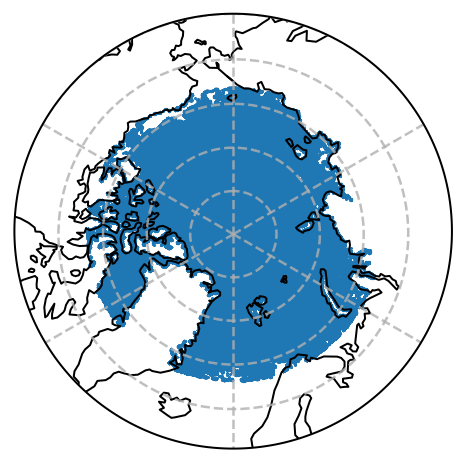

In [158]:
plot.scatter_from_dataset(lonlatFinal[0,:,0], 
                          lonlatFinal[0,:,1], 
                          latRange = (60,90),
                          polar=True,
                          s=0.3)

In [218]:
np.expand-np.zeros_like(myBinsOver70.bindex).shape

(12366,)

In [18]:
ensembleCommunityID_201809_over70 = {}
codelengths_201809_over70 = []
globalMixing_201809_over70 = []
globalCoherence_201809_over70 = []

avg_mixing_201809_over70 = np.zeros_like(myBinsOver70.bindex)
avg_coherence_201809_over70 = np.zeros_like(myBinsOver70.bindex)
avg_boundary_201809_over70 = np.zeros_like(myBinsOver70.bindex)
boundaries_over70 = np.zeros((myBinsOver70.bindex.shape[0], 100))
avg_global_mixing_201809_over70 = 0
avg_global_coherence_201809_over70 = 0

for run in range(1, 101):
    myBinsOver70.load_communities(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel_mt2/masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel_mt2_multirunN{run}.clu")
    ensembleCommunityID_201809_over70[run-1] = myBinsOver70.communityID
    codelengths_201809_over70.append(myBinsOver70.codelength)
    
    myBinsOver70.find_adjacency();
    avg_boundary_201809_over70 = avg_boundary_201809_over70 + myBinsOver70.flag_on_boundary();
    myBinsOver70.color_communities();
    avg_coherence_201809_over70 = avg_coherence_201809_over70 + myBinsOver70.calculate_coherence_ratio(transMat_20180301_over70);
    avg_mixing_201809_over70 = avg_mixing_201809_over70 + myBinsOver70.calculate_mixing(transMat_20180301_over70);
    avg_global_coherence_201809_over70 = avg_global_coherence_201809_over70 + myBinsOver70.calculate_global_coherence()
    avg_global_mixing_201809_over70 = avg_global_mixing_201809_over70 + myBinsOver70.calculate_global_mixing()
    globalMixing_201809_over70.append(myBinsOver70.globalMixing)
    globalCoherence_201809_over70.append(myBinsOver70.globalCoherenceRatio)
    boundaries_over70[:, run-1] = myBinsOver70.onBoundary
    
avg_mixing_201809_over70 = avg_mixing_201809_over70/100
avg_coherence_201809_over70 = avg_coherence_201809_over70/100
avg_boundary_201809_over70 = avg_boundary_201809_over70/100
avg_global_mixing_201809_over70 = avg_global_mixing_201809_over70/100
avg_global_coherence_201809_over70 = avg_global_coherence_201809_over70/100
print("Average Global Coherence Ratio", avg_global_coherence_201809_over70)
print("Average Global Mixing Parameter", avg_global_mixing_201809_over70)

Average Global Coherence Ratio 0.8018739010162541
Average Global Mixing Parameter 0.35723470748374814


In [19]:
with open("average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", "rb") as pickFile:
    avg_boundary_201809 = pickle.load(pickFile)

In [20]:
svDomainMask70 = np.logical_and(myBinsOver70.svDomainMask, (myBinsOver70.svTriCenterLats > 70)[myBinsOver70.svSimplices[:,0]])

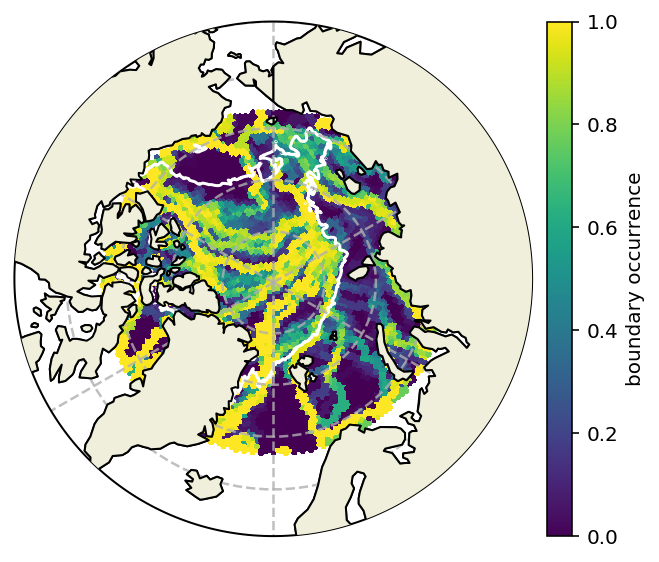

In [21]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[svDomainMask70],
                                             avg_boundary_201809_over70[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][svDomainMask70]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = 'viridis', vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201809.longitude, ice_ds_201809.latitude[1680:], ice_ds_201809.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel_mt2.png", dpi=300, bbox_inches='tight')

In [38]:
std_degeneracy = np.mean(np.std(boundaries_over70[myBinsOver70.oceanMask], axis=1))

In [29]:
mask_exceed_boundary_std = np.abs(avg_boundary_201809 - avg_boundary_201809_over70)>(np.std(boundaries_over70, axis=1))

In [42]:
avg_boundary_201809_over70_significant = np.where(mask_exceed_boundary_std, (avg_boundary_201809 - avg_boundary_201809_over70), np.nan)
avg_boundary_201809_over70_significant = np.ma.masked_array(avg_boundary_201809_over70_significant, np.isnan(avg_boundary_201809_over70_significant))

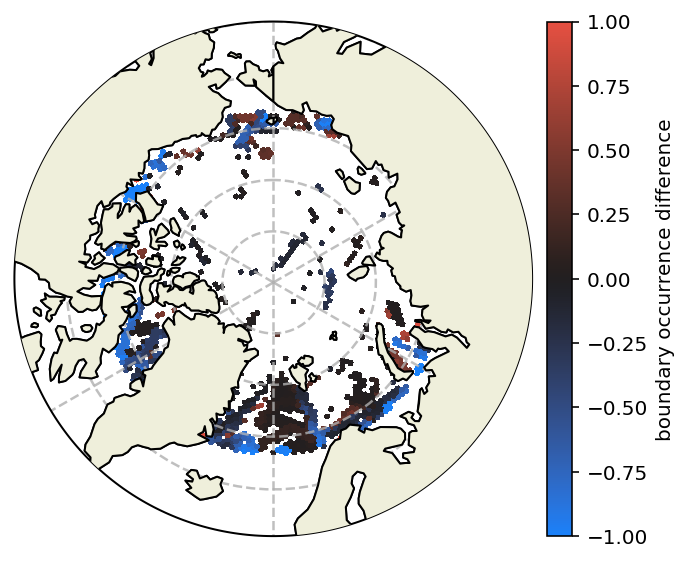

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[svDomainMask70],
                                             avg_boundary_201809_over70_significant[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][svDomainMask70]], 
                                             lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.bkr, vmin=-1, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence difference"
                                            )
plt.savefig(f"figures/difference_in_average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico7_over70subsel_mt2_significant", dpi=300, bbox_inches='tight')